In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.ticker as ticker
import numpy as np
import datetime

import os
path = os.getcwd()

In [2]:
# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [3]:
df= pd.read_csv('data/df_for_regression.csv')
df.head()

,Unnamed: 0,Store ID,Item ID,Store Category,Store Segment,Store Region,City,Item Last Supplying Date,Supply Length,Region Language,Region Type,Cluster,Item_trailing_3_m_supply_date,Item Price,Declared Supply,Meals Saved,Total Supply,Pickup Length
0,0,35,34,Indie - Outbound,Bakery,Vaud,Salavaux,2022-03-01,999,french,urban,3,2021-12-01,6.9,3.14,3.05,3.29,20.0
1,1,57,73,Indie - Outbound,Bakery,Freiburg,Sâles,2022-03-01,997,french,urban,3,2021-12-01,6.9,1.94,2.09,2.26,30.0
2,2,58,74,Indie - Outbound,Bakery,Freiburg,Ursy,2022-02-26,976,french,urban,3,2021-11-28,4.9,0.00,1.33,1.37,30.0
3,3,58,337173,Indie - Outbound,Bakery,Freiburg,Ursy,2020-12-29,1,french,urban,3,2020-09-30,4.9,1.00,0.67,0.67,30.0
4,4,61,79,Indie - Outbound,Traditional Restaurant,Vaud,Lausanne,2022-02-26,960,french,urban,3,2021-11-28,6.9,1.00,0.97,1.00,30.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9735 entries, 0 to 9734
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     9735 non-null   int64  
 1   Store ID                       9735 non-null   int64  
 2   Item ID                        9735 non-null   int64  
 3   Store Category                 9735 non-null   object 
 4   Store Segment                  9735 non-null   object 
 5   Store Region                   9735 non-null   object 
 6   City                           9735 non-null   object 
 7   Item Last Supplying Date       9735 non-null   object 
 8   Supply Length                  9735 non-null   int64  
 9   Region Language                9735 non-null   object 
 10  Region Type                    9735 non-null   object 
 11  Cluster                        9735 non-null   int64  
 12  Item_trailing_3_m_supply_date  9735 non-null   o

## Data Preprocessing

In [5]:
# Check for duplicates
df.duplicated().sum()

0

In [6]:
# Check for nan:
df.isnull().sum().sort_values(ascending=False)

Unnamed: 0                       0
Store ID                         0
Total Supply                     0
Meals Saved                      0
Declared Supply                  0
Item Price                       0
Item_trailing_3_m_supply_date    0
Cluster                          0
Region Type                      0
Region Language                  0
Supply Length                    0
Item Last Supplying Date         0
City                             0
Store Region                     0
Store Segment                    0
Store Category                   0
Item ID                          0
Pickup Length                    0
dtype: int64

In [7]:
# Remove columns:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
df2 = df.drop(columns=['Meals Saved','Supply Length','Declared Supply','Store ID','Item ID','Item Last Supplying Date','City','Item_trailing_3_m_supply_date'])

In [9]:
#Removing outliers:
df=df[df['Total Supply']<=6]

### Define X and y

In [10]:
# Remove columns: define X and y
X = df.drop(columns=['Meals Saved','Supply Length','Declared Supply','Total Supply','Store ID','Item ID','Item Last Supplying Date','City','Item_trailing_3_m_supply_date'])
y = df['Total Supply']

In [11]:
X.head()

,Store Category,Store Segment,Store Region,Region Language,Region Type,Cluster,Item Price,Pickup Length
0,Indie - Outbound,Bakery,Vaud,french,urban,3,6.9,20.0
1,Indie - Outbound,Bakery,Freiburg,french,urban,3,6.9,30.0
2,Indie - Outbound,Bakery,Freiburg,french,urban,3,4.9,30.0
3,Indie - Outbound,Bakery,Freiburg,french,urban,3,4.9,30.0
4,Indie - Outbound,Traditional Restaurant,Vaud,french,urban,3,6.9,30.0


In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9192 entries, 0 to 9734
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store Category   9192 non-null   object 
 1   Store Segment    9192 non-null   object 
 2   Store Region     9192 non-null   object 
 3   Region Language  9192 non-null   object 
 4   Region Type      9192 non-null   object 
 5   Cluster          9192 non-null   int64  
 6   Item Price       9192 non-null   float64
 7   Pickup Length    9192 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 646.3+ KB


In [13]:
X.describe()

,Cluster,Item Price,Pickup Length
count,9192.000000,9192.000000,9192.000000
mean,1.370757,7.631485,88.581599
std,1.624279,5.230675,136.033419
min,0.000000,0.010000,0.000000
25%,0.000000,5.900000,30.000000
50%,0.000000,5.900000,30.000000
75%,3.000000,6.900000,60.000000
max,4.000000,94.900000,1185.000000


# Model 1: y=Total Supply

In [14]:
# Split into Train/Test -> to do on all dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
num_transformer = make_pipeline(RobustScaler())    #### Removed Simple Imputer
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
preprocess = make_column_transformer((num_transformer, ['Item Price','Pickup Length']),
                                     (cat_transformer,['Store Category', 'Store Segment', 'Store Region', 'Region Language', 'Region Type','Cluster']))

In [16]:
# visualizing pipelines in HTML
set_config(display='diagram')
preprocess

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['Item Price', 'Pickup Length']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Store Category', 'Store Segment',
                                  'Store Region', 'Region Language',
                                  'Region Type', 'Cluster'])])

In [17]:
X_train_transformed = preprocess.fit_transform(X_train)

In [18]:
display(pd.DataFrame(X_train_transformed.todense()).head(3))

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,2.0,0.853333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.220333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [19]:
pd.DataFrame(X_train_transformed.todense(),columns=preprocess.get_feature_names_out())

,pipeline-1__Item Price,pipeline-1__Pickup Length,pipeline-2__Store Category_Indie - Inbound,pipeline-2__Store Category_Indie - Outbound,pipeline-2__Store Category_Key Account,pipeline-2__Store Category_Manufacturer,pipeline-2__Store Segment_Bakery,pipeline-2__Store Segment_Beverages,pipeline-2__Store Segment_Buffet,pipeline-2__Store Segment_Butcher,...,pipeline-2__Region Language_french,pipeline-2__Region Language_german,pipeline-2__Region Language_italien,pipeline-2__Region Type_rural,pipeline-2__Region Type_urban,pipeline-2__Cluster_0,pipeline-2__Cluster_1,pipeline-2__Cluster_2,pipeline-2__Cluster_3,pipeline-2__Cluster_4
0,2.0,0.853333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.220333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.960667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.017667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6429,-1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6430,1.0,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
6431,2.0,1.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6432,-1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


### Linear Regression

In [20]:
# Add Estimator
pipe = make_pipeline(preprocess, LinearRegression())
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Item Price',
                                                   'Pickup Length']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Store Category',
                                                   'Store Segment',
                                                   'Store Region',
                                                   'Region Language',
                                                   'Region Type',
                                                   'Cluster'])])),
                ('linearregression', LinearRegression())])

In [21]:
# Train pipeline, make predictions, score model
pipe.fit(X_train,y_train)
pipe.predict(X_test)
pipe.score(X_test,y_test)

0.1494158033357268

In [22]:
# Cross validate pipeline
cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()

0.16029645380141022

### Ridge

In [25]:
# Add Estimator
pipe2 = make_pipeline(preprocess, Ridge())
pipe2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Item Price',
                                                   'Pickup Length']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Store Category',
                                                   'Store Segment',
                                                   'Store Region',
                                                   'Region Language',
                                                   'Region Type',
                                                   'Cluster'])])),
                ('ridge', Ridge())])

In [26]:
pipe2.fit(X_train,y_train)
pipe2.predict(X_test)
pipe2.score(X_test,y_test)

0.1502633448108568

In [27]:
# Cross validate pipeline
cross_val_score(pipe2, X_train, y_train, cv=5, scoring='r2').mean()

0.1612316980218859

### Lasso

In [28]:
# Add Estimator
pipe3 = make_pipeline(preprocess, Lasso())
pipe3

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Item Price',
                                                   'Pickup Length']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Store Category',
                                                   'Store Segment',
                                                   'Store Region',
                                                   'Region Language',
                                                   'Region Type',
                                                   'Cluster'])])),
                ('lasso', Lasso())])

In [29]:
pipe3.fit(X_train,y_train)
pipe3.predict(X_test)
pipe3.score(X_test,y_test)

-0.0012343515247377201

In [30]:
# Cross validate pipeline
cross_val_score(pipe3, X_train, y_train, cv=5, scoring='r2').mean()

-0.0011203081379528967

### Elastic Net

In [31]:
### Elastic Net
pipe4 = make_pipeline(preprocess, ElasticNet(alpha=1, l1_ratio=0.2))

In [ ]:
"""pipe2 = make_pipeline(preprocess, ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.8,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False))"""

In [32]:
pipe4.fit(X_train,y_train)
pipe4.predict(X_test)
pipe4.score(X_test,y_test)

-6.81193564591176e-05

In [33]:
# Cross validate pipeline
cross_val_score(pipe4, X_train, y_train, cv=5, scoring='r2').mean()

-0.00022164010908969355

### Grid Search

In [34]:
# Train/Val
X_train_gs, X_val, y_train_gs, y_val = train_test_split(X_train_transformed, y_train, test_size=0.20, random_state=1)

# Instanciate model
model = ElasticNet()

# Hyperparameter Grid
grid = {'alpha': [0.01, 0.1, 1], 
        'l1_ratio': [0.2, 0.5, 0.8]}

# Instanciate Grid Search
search = GridSearchCV(model, grid, 
                           scoring = 'r2',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          ) 

# Fit data to Grid Search
search.fit(X_train_gs,y_train_gs);
search.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.2)

In [35]:
# Best score
search.best_score_

0.16218512927700296

In [37]:
# Best Params
search.best_params_

{'alpha': 0.01, 'l1_ratio': 0.2}

In [38]:
# Best estimator
search.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.2)

In [39]:
model1 = LinearRegression()
parameters = {"fit_intercept": [True, False],
             }
search1 = GridSearchCV(estimator=model1, param_grid = parameters, scoring='r2', cv = 5, n_jobs=-1)
search1.fit(X_train_gs,y_train_gs)
search1.best_score_

0.15748402074018944

In [40]:
# Best Params
search1.best_params_

{'fit_intercept': True}

##### BEST MODEL IS ELASTIC NET WITH ALPHA=0.01 AND RATIO 0.2

In [41]:
pipe5 = make_pipeline(preprocess, ElasticNet(alpha=0.01, l1_ratio=0.2))

In [69]:
pipe5

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Item Price',
                                                   'Pickup Length']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Store Category',
                                                   'Store Segment',
                                                   'Store Region',
                                                   'Region Language',
                                                   'Region Type',
                                                   'Cluster'])])),
                ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.2))])

In [42]:
pipe5.fit(X_train,y_train)
pipe5.predict(X_test)
pipe5.score(X_test,y_test)

0.1520169455919892

In [43]:
# Cross validate pipeline
cross_val_score(pipe5, X_train, y_train, cv=5, scoring='r2').mean()

0.15820038247585147

In [77]:
coeff=list(pipe5[1].coef_)
coeff

[4.358635402862176e-05,
 -0.0008784387547880729,
 0.05450238204638488,
 -0.0,
 0.05084007980340491,
 -0.1156290133738758,
 0.4277195764443814,
 0.2922437606387977,
 0.3860556641555653,
 -0.04082260261396992,
 -0.21592107941826252,
 0.07772343446209692,
 -0.0,
 -0.0,
 0.0,
 0.0,
 -0.4493398167195471,
 0.05350311551698761,
 -0.1155056959851297,
 0.0,
 -0.0,
 0.0,
 -0.0,
 -0.0241701849685266,
 0.1851457805115997,
 -0.2724595084924076,
 -0.7768704878141138,
 0.07679659205306417,
 0.05837845123865156,
 0.07416436207439725,
 -0.0,
 0.0,
 0.006590971484075448,
 0.0066085473691335165,
 -0.1006015070812896,
 -0.0355099602939211,
 0.1909402984014063,
 0.0,
 -0.16734313419140975,
 -0.0,
 -0.04430123235487806,
 0.0,
 -0.0,
 -0.0,
 0.0,
 0.0,
 0.04681626183877427,
 0.0,
 0.0,
 -0.04883662212128054,
 -0.0,
 -0.1492499875156342,
 0.0,
 -0.13219727966861175,
 0.17655590755551842,
 -0.0,
 0.06604646283992131,
 -0.0488947149352937,
 -0.0,
 0.0,
 -0.08783063446912304,
 -0.0,
 0.0,
 -0.08447025879776837,


In [85]:
features=pd.DataFrame(X_train_transformed.todense(),columns=preprocess.get_feature_names_out()).columns.to_list()
features

['pipeline-1__Item Price',
 'pipeline-1__Pickup Length',
 'pipeline-2__Store Category_Indie - Inbound',
 'pipeline-2__Store Category_Indie - Outbound',
 'pipeline-2__Store Category_Key Account',
 'pipeline-2__Store Category_Manufacturer',
 'pipeline-2__Store Segment_Bakery',
 'pipeline-2__Store Segment_Beverages',
 'pipeline-2__Store Segment_Buffet',
 'pipeline-2__Store Segment_Butcher',
 'pipeline-2__Store Segment_Cafeteria',
 'pipeline-2__Store Segment_Canteen',
 'pipeline-2__Store Segment_Caterer',
 'pipeline-2__Store Segment_Fast Food / Take away restaurant',
 'pipeline-2__Store Segment_Fish shop',
 'pipeline-2__Store Segment_Fruits & vegetables store',
 'pipeline-2__Store Segment_Gas station',
 'pipeline-2__Store Segment_Hotel',
 'pipeline-2__Store Segment_Manufacturer',
 'pipeline-2__Store Segment_Market stall',
 'pipeline-2__Store Segment_No_Segment',
 'pipeline-2__Store Segment_Other',
 'pipeline-2__Store Segment_Other Specialists',
 'pipeline-2__Store Segment_Pastry',
 'pipeli

In [72]:
pipe5[1].intercept_ 

2.053071594866453

In [86]:
# model coefficients:
d = dict(zip(features, coeff))
d

{'pipeline-1__Item Price': 4.358635402862176e-05,
 'pipeline-1__Pickup Length': -0.0008784387547880729,
 'pipeline-2__Store Category_Indie - Inbound': 0.05450238204638488,
 'pipeline-2__Store Category_Indie - Outbound': -0.0,
 'pipeline-2__Store Category_Key Account': 0.05084007980340491,
 'pipeline-2__Store Category_Manufacturer': -0.1156290133738758,
 'pipeline-2__Store Segment_Bakery': 0.4277195764443814,
 'pipeline-2__Store Segment_Beverages': 0.2922437606387977,
 'pipeline-2__Store Segment_Buffet': 0.3860556641555653,
 'pipeline-2__Store Segment_Butcher': -0.04082260261396992,
 'pipeline-2__Store Segment_Cafeteria': -0.21592107941826252,
 'pipeline-2__Store Segment_Canteen': 0.07772343446209692,
 'pipeline-2__Store Segment_Caterer': -0.0,
 'pipeline-2__Store Segment_Fast Food / Take away restaurant': -0.0,
 'pipeline-2__Store Segment_Fish shop': 0.0,
 'pipeline-2__Store Segment_Fruits & vegetables store': 0.0,
 'pipeline-2__Store Segment_Gas station': -0.4493398167195471,
 'pipeli

# DATA VISUALIZATION

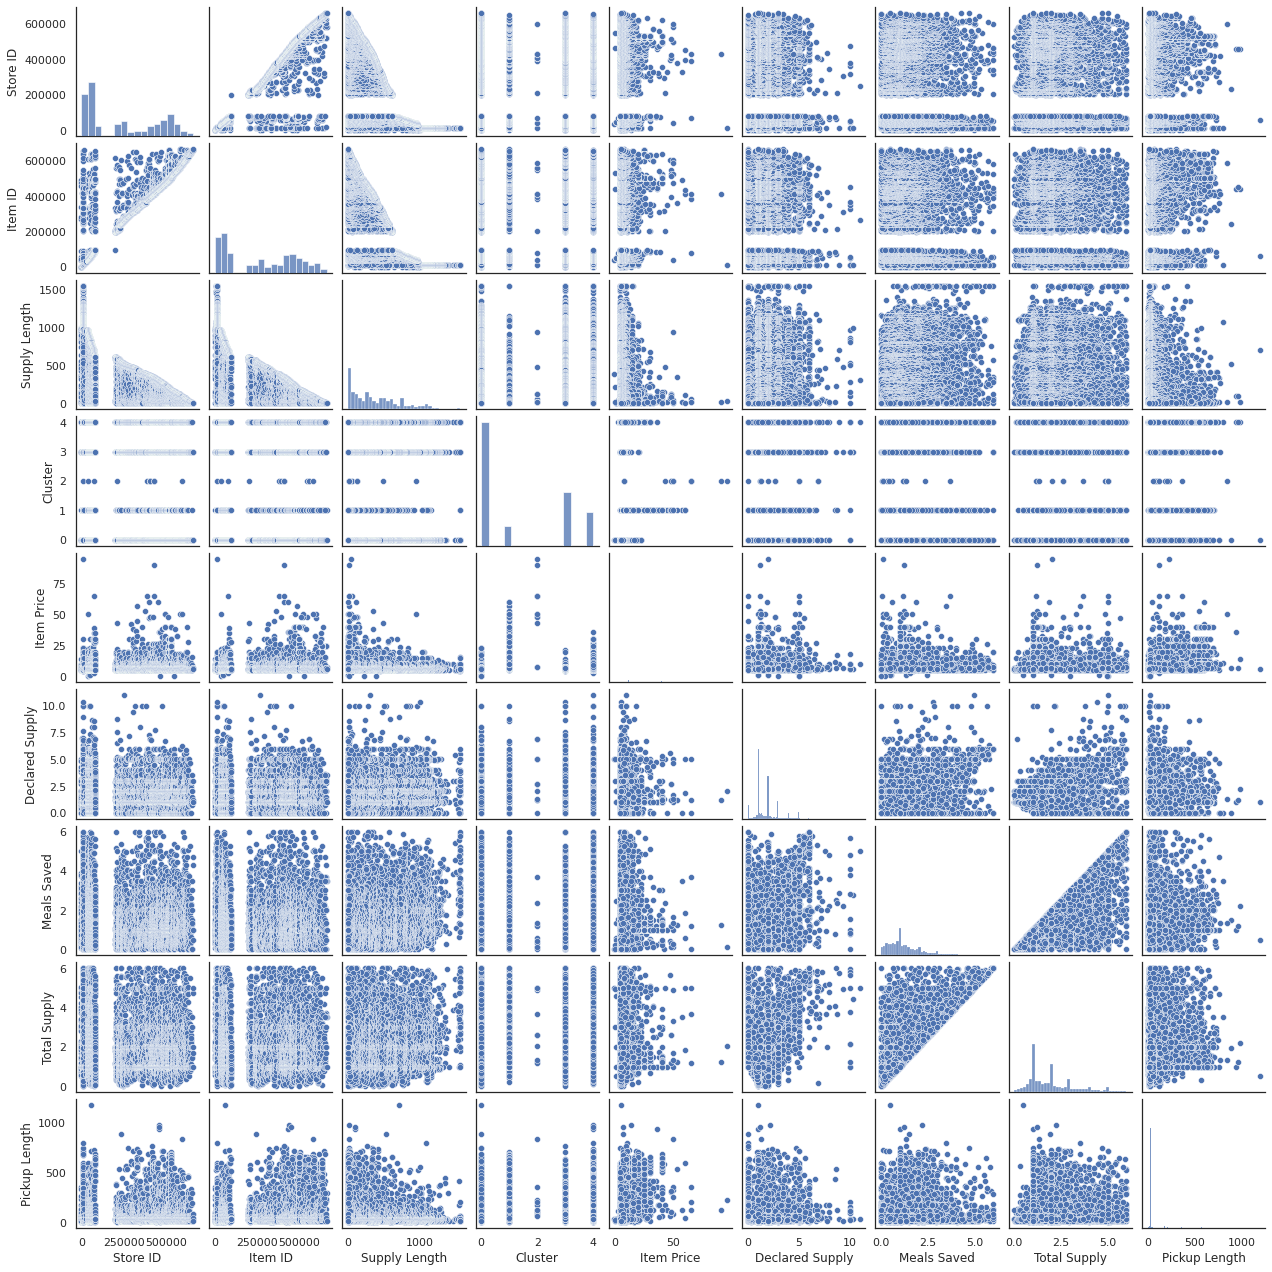

In [44]:
sns.set(style='white')
sns.pairplot(df, height=2)
plt.show()

[(0.0, 7.0)]

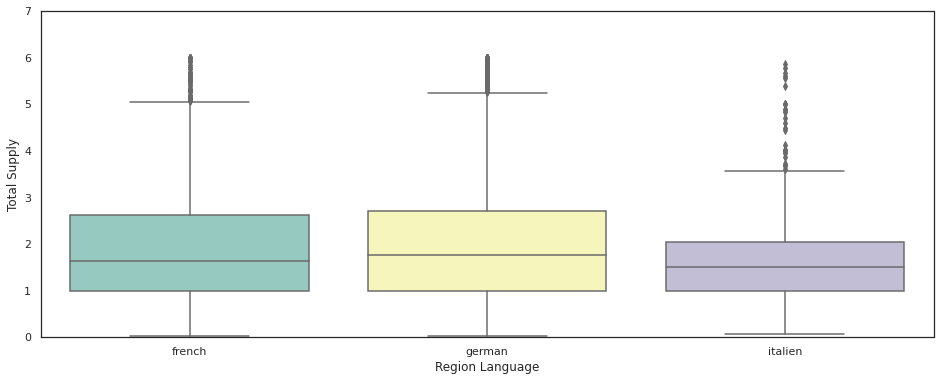

In [53]:
# Total Supply by Language
plt.figure(figsize=(16, 6))
sns.boxplot(x='Region Language', y='Total Supply',
                 data=df, palette="Set3").set(ylim=(0, 7))

[(0.0, 7.0)]

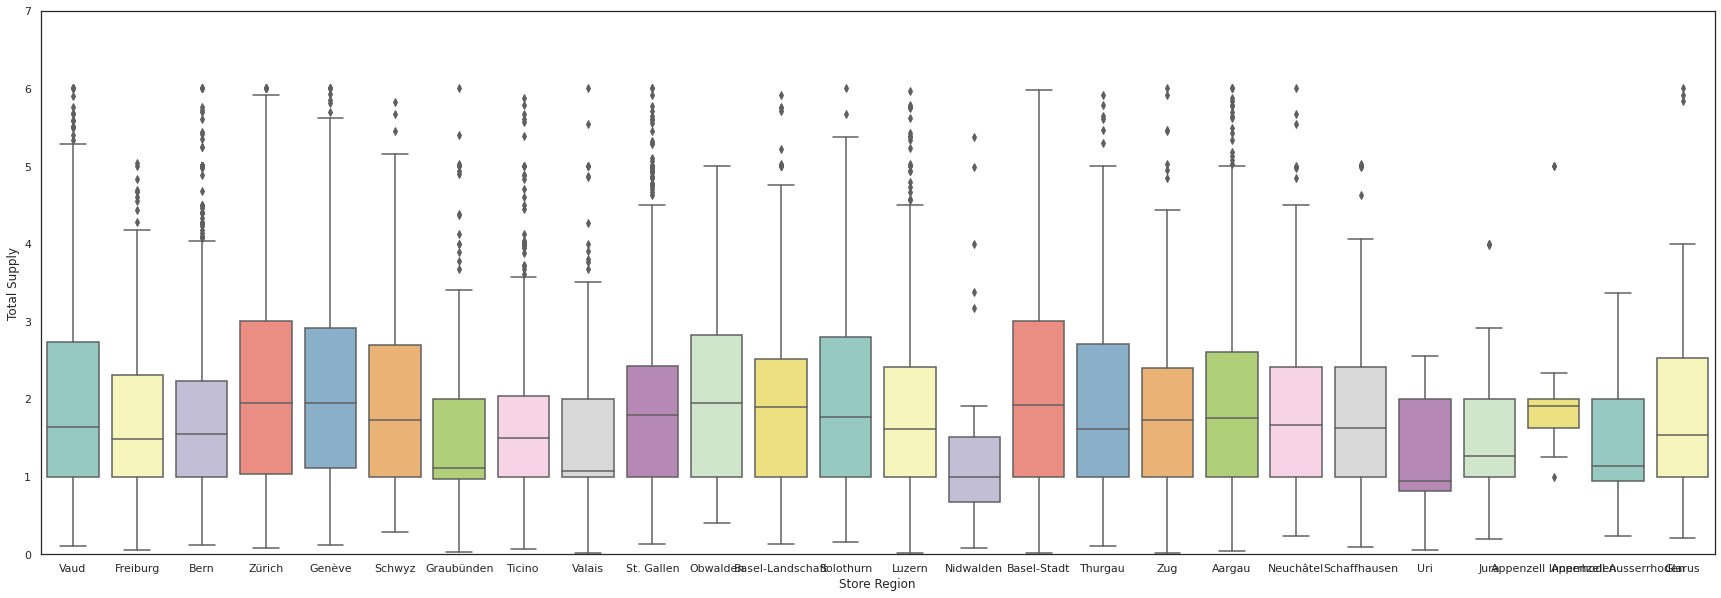

In [55]:
# Total Supply by Region
plt.figure(figsize=(30, 10))
sns.boxplot(x='Store Region', y='Total Supply',
                 data=df, palette="Set3").set(ylim=(0, 7))

[(0.0, 7.0)]

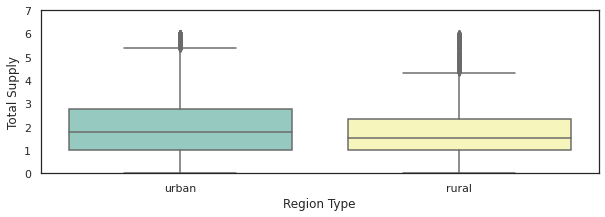

In [56]:
# Total Supply by Region Type
plt.figure(figsize=(10, 3))
sns.boxplot(x='Region Type', y='Total Supply',
                 data=df, palette="Set3").set(ylim=(0, 7))

[(0.0, 7.0)]

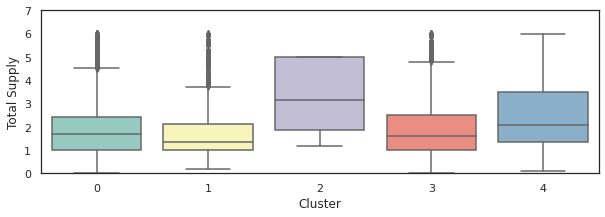

In [57]:
# Total Supply by Cluster
plt.figure(figsize=(10, 3))
sns.boxplot(x='Cluster', y='Total Supply',
                 data=df, palette="Set3").set(ylim=(0, 7))

[(0.0, 7.0)]

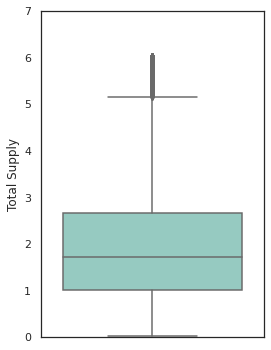

In [60]:
# Total Supply distribution
plt.figure(figsize=(4, 6))
sns.boxplot(y='Total Supply',
                 data=df, palette="Set3").set(ylim=(0, 7))

<AxesSubplot:xlabel='Total Supply', ylabel='Count'>

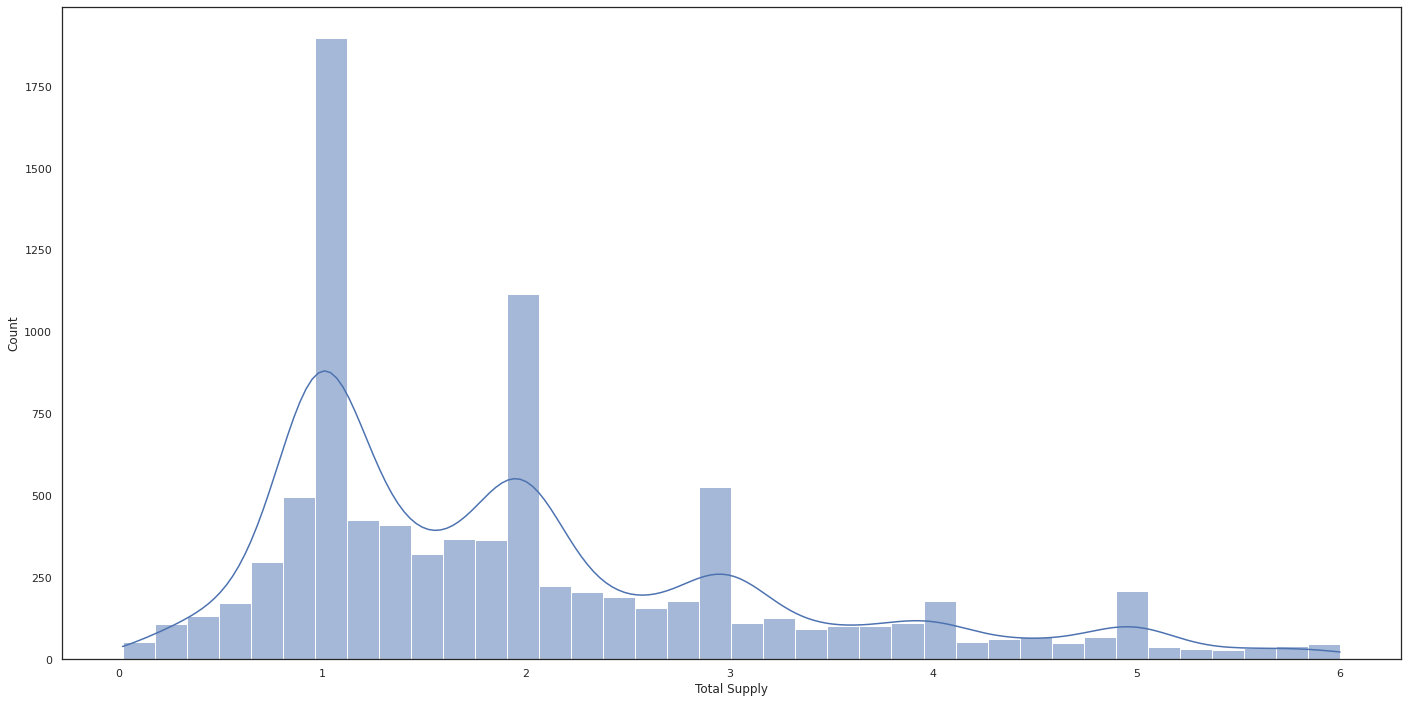

In [61]:
plt.figure(figsize=(24, 12))
sns.histplot(df['Total Supply'], kde=True)

In [67]:
df['Total Supply'].value_counts().sort_index()

0.02     4
0.03     1
0.04     1
0.05     3
0.06     2
        ..
5.92     2
5.93     1
5.96     1
5.98     1
6.00    30
Name: Total Supply, Length: 582, dtype: int64

In [68]:
import joblib
joblib.dump(pipe5, 'linear_regression_supply.joblib')

['linear_regression_supply.joblib']